<a href="https://colab.research.google.com/github/rickychen0606/knapsack/blob/main/%E8%B2%93%E7%8B%97%E5%9C%96%E5%83%8F%E5%88%86%E9%A1%9E%E8%88%87Grad_CAM%E5%8F%AF%E8%A6%96%E5%8C%96(%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**掛載 Google 雲端硬碟**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# 定義路徑（你可以修改這裡）
zip_train_path = '/content/drive/MyDrive/2025_Spring/人工智慧概論(資管課)/貓狗圖像分類與Grad-CAM可視化(遷移學習)/train.zip'
zip_test_path = '/content/drive/MyDrive/2025_Spring/人工智慧概論(資管課)/貓狗圖像分類與Grad-CAM可視化(遷移學習)/test1.zip'

# 解壓縮到 Colab 本地（避免慢）
extract_train_to = '/content/data/train'
extract_test_to = '/content/data/test1'

# 建立資料夾
os.makedirs(extract_train_to, exist_ok=True)
os.makedirs(extract_test_to, exist_ok=True)

# 解壓 train.zip
with zipfile.ZipFile(zip_train_path, 'r') as zip_ref:
    zip_ref.extractall(extract_train_to)

# 解壓 test1.zip
with zipfile.ZipFile(zip_test_path, 'r') as zip_ref:
    zip_ref.extractall(extract_test_to)

print("✅ 解壓縮完成")


✅ 解壓縮完成


In [3]:
# 看看有幾張圖片被解壓
print("Train images:", len(os.listdir('/content/data/train/train')))
print("Test images:", len(os.listdir('/content/data/test1/test1')))


Train images: 25000
Test images: 12500


# 準備資料夾與分類圖片

In [4]:
import os
import shutil

original_path = '/content/data/train/train'   # ✅ 修正後路徑
target_path = 'data_split/train'              # 建立分類資料夾在這裡

os.makedirs(os.path.join(target_path, 'cat'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'dog'), exist_ok=True)

for fname in os.listdir(original_path):
    if fname.startswith('cat'):
        shutil.copy(os.path.join(original_path, fname), os.path.join(target_path, 'cat', fname))
    elif fname.startswith('dog'):
        shutil.copy(os.path.join(original_path, fname), os.path.join(target_path, 'dog', fname))

print("✅ 已分類圖片到 cat/dog")


✅ 已分類圖片到 cat/dog


In [5]:
# ✅ 將測試圖片放入 Keras 相容的 unknown 資料夾
test_source = '/content/data/test1/test1'
test_target = 'data_split/test/unknown'

os.makedirs(test_target, exist_ok=True)

for fname in os.listdir(test_source):
    shutil.copy(os.path.join(test_source, fname), os.path.join(test_target, fname))

print("✅ 已整理 test1 圖片至 test/unknown/")


✅ 已整理 test1 圖片至 test/unknown/


# 載入訓練與驗證資料

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 建立遷移學習模型（VGG16 / ResNet50 / EfficientNetB0）

In [7]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_model(base_model_fn, input_shape=(224, 224, 3)):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# 訓練三個模型

In [8]:
models = {
    "VGG16": build_model(VGG16),
    "ResNet50": build_model(ResNet50),
    "EfficientNetB0": build_model(EfficientNetB0)
}

histories = {}

for name, model in models.items():
    print(f"\n📌 開始訓練模型：{name}")
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator
    )
    histories[name] = (model, history)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

📌 開始訓練模型：VGG16
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.8089 - loss: 0.4011 - val_accuracy: 0.9158 - val_loss: 0.2104
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.9129 - loss: 0.2122 - val_accuracy: 0.9010 - val_loss: 0.2211
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 208ms/step - accuracy: 0.9168 - loss: 0.1985 - val_accuracy: 0.9274 - val_loss: 0.1834
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 207ms/step - accuracy: 0.9181 - loss: 0.1938 - val_accuracy: 0.9144 - val_loss: 0.2005
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.9215 - loss: 0.1891 - val_accuracy: 0.9284 - val_loss: 0.1748

📌 開始訓練模型：ResNet50
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 117ms/step - accuracy: 0.5535 - loss: 0.7071 - val_accuracy: 0.6242 - val_loss: 0.6551
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.6050 - loss: 0.6597 - val_accuracy: 0.6070 - val_loss: 0.6576
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.6144 - l

# 畫出訓練曲線（accuracy/loss）

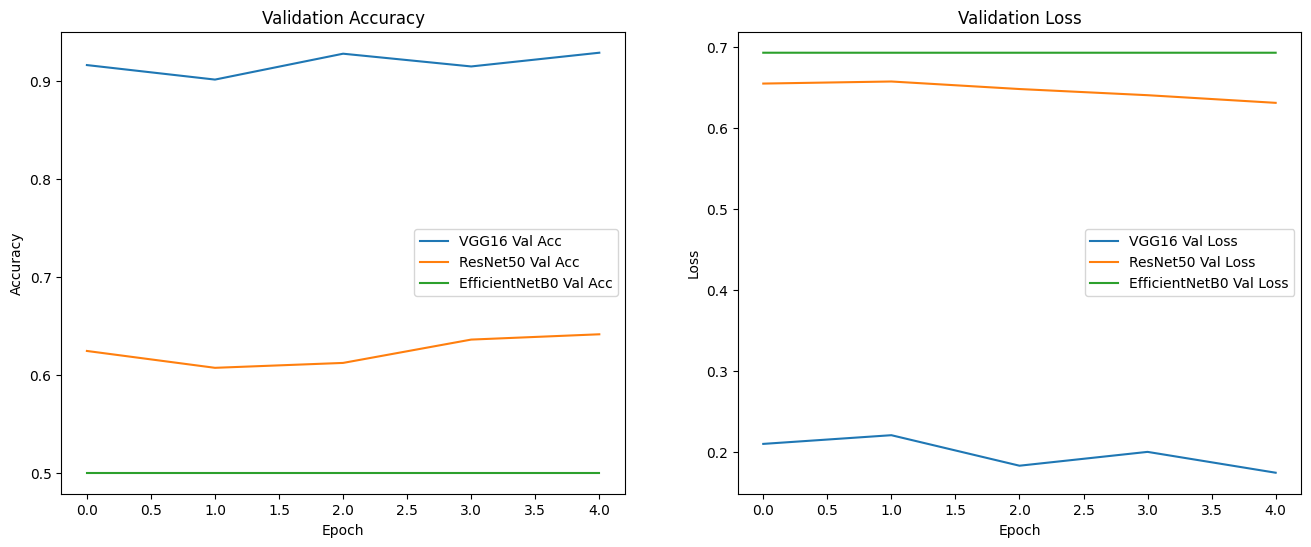

In [9]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, (_, history) in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for name, (_, history) in histories.items():
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_histories(histories)


# Grad-CAM 可視化函數（通用）

In [10]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    return np.expand_dims(array / 255.0, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# 執行 Grad-CAM 可視化（每模型 1 張）


🔥 Grad-CAM - VGG16


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


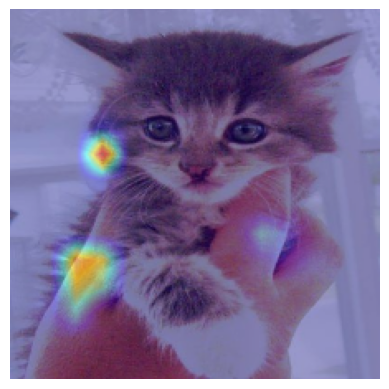


🔥 Grad-CAM - ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_23']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


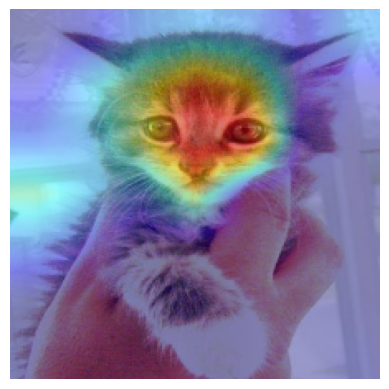


🔥 Grad-CAM - EfficientNetB0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_202']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-10-ebf91edf3351>:30: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


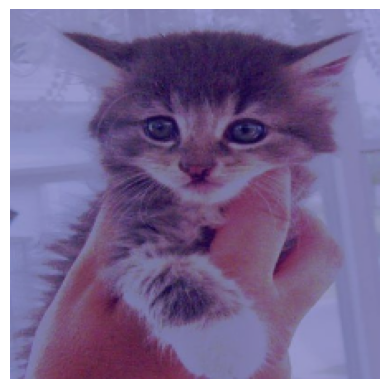

In [11]:
# 測試圖片
img_path = '/content/data_split/train/cat/cat.100.jpg'  # 或 dog.100.jpg

# 模型對應最後一層卷積層名稱
last_layers = {
    "VGG16": 'block5_conv3',
    "ResNet50": 'conv5_block3_out',
    "EfficientNetB0": 'top_conv'
}

for name, (model, _) in histories.items():
    print(f"\n🔥 Grad-CAM - {name}")
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_layers[name])
    overlay_heatmap(img_path, heatmap)
